https://dacon.io/competitions/official/235687/overview/description/

EDA 분석을 해보자


In [ ]:
!pip install pycaret

In [ ]:
# from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

from google.colab import drive

drive.mount('/content/drive')


PATH = '/content/drive/My Drive/Colab Notebooks/data/시스템품질변화/'

Mounted at /content/drive


In [ ]:
train_err  = pd.read_csv(PATH+'train/train_err_data.csv')
train_quality  = pd.read_csv(PATH+'train/train_quality_data.csv')
train_problem  = pd.read_csv(PATH+'train/train_problem_data.csv')
submission  = pd.read_csv(PATH+'sample_submission.csv ')

test_err  = pd.read_csv(PATH+'test/test_err_data.csv')
test_quality  = pd.read_csv(PATH+'test/test_quality_data.csv')

In [ ]:
submission  = pd.read_csv(PATH+'sample_submission.csv')


In [ ]:
# train_err
print("-- Size -- ")
print(f"train_err : {train_err.shape}")
print(f"test_err  : {test_err.shape}")

# train_quality
print("-- Size -- ")
print(f"train_quality : {train_quality.shape}")
print(f"test_quality  : {test_quality.shape}")

-- Size -- 
train_err : (16554663, 6)
test_err  : (16532648, 6)
-- Size -- 
train_quality : (828624, 16)
test_quality  : (747972, 16)


In [ ]:
# Train/Test-set은 어떻게 분리되었을까?
display(train_err.head(2))
display(train_err.tail(2))
display(test_err.head(2))
display(test_err.tail(2))

,user_id,time,model_nm,fwver,errtype,errcode
0,10000,20201101025616,model_3,05.15.2138,15,1
1,10000,20201101030309,model_3,05.15.2138,12,1


,user_id,time,model_nm,fwver,errtype,errcode
16554661,24999,20201130172631,model_3,05.15.2138,4,0
16554662,24999,20201130210625,model_3,05.15.2138,15,1


,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2


,user_id,time,model_nm,fwver,errtype,errcode
16532646,44998,20201130212259,model_1,04.16.3553,16,1
16532647,44998,20201130212316,model_1,04.16.3553,31,0


In [ ]:
# train_err / test_err의 user_id는?
display("train_err", train_err['user_id'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['user_id'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min    10000
max    24999
Name: user_id, dtype: int64

Size : 16554663


'test_err'

min    30000
max    44998
Name: user_id, dtype: int64

Size : 16532648


In [ ]:
# train_quality / test_quality 의 user_id는?
display("train_quality", train_quality['user_id'].agg(['min','max']) )
print(f'Size : {len(train_quality)}')

print('='* 80)
display("test_quality",  test_quality['user_id'].agg(['min','max']) )
print(f'Size : {len(test_quality)}')

'train_quality'

min    10000
max    24997
Name: user_id, dtype: int64

Size : 828624


'test_quality'

min    30000
max    44997
Name: user_id, dtype: int64

Size : 747972


In [ ]:
# train_err / test_err 의 time는?
display("train_err",  train_err['time'].agg(['min','max']) )
print(f'Size : {len(train_err)}')

print('='* 80)

display("test_err",  test_err['time'].agg(['min','max']) )
print(f'Size : {len(test_err)}')

'train_err'

min    20201031235959
max    20201202185152
Name: time, dtype: int64

Size : 16554663


'test_err'

min    20201031235959
max    20201214120118
Name: time, dtype: int64

Size : 16532648


In [ ]:
# train_quality / test_quality 의 date는?
display("train_quality",  train_quality['time'].agg(['min','max']) )
print(f'Size : {len(train_quality)}')

print('='* 80)

display("test_quality",  test_quality['time'].agg(['min','max']) )
print(f'Size : {len(test_quality)}')

'train_quality'

min    20201031235000
max    20201130234000
Name: time, dtype: int64

Size : 828624


'test_quality'

min    20201031235000
max    20201130234000
Name: time, dtype: int64

Size : 747972


시간별로 얼마나 data나왔나

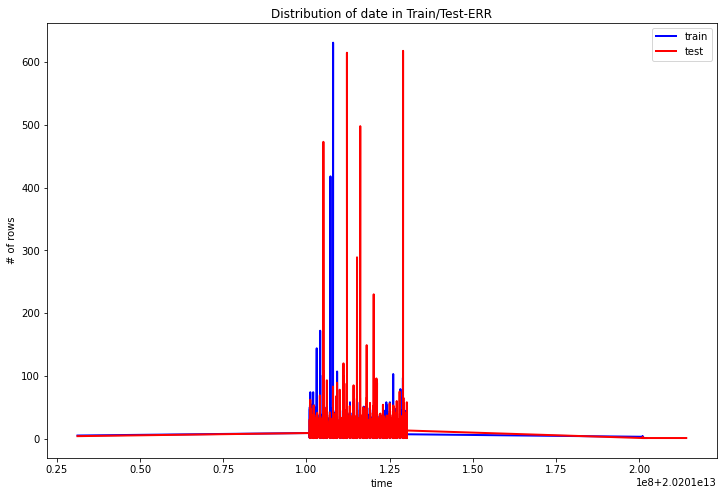

In [ ]:
# train_err / test_err - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
train_err['time'].value_counts().sort_index().plot(color='b', lw=2, label='train')
test_err['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-ERR");

Train-set에 있는 고유한 user_id 개수 : 15000
Test-set에 있는 고유한 user_id 개수 : 14998
Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : 0
Train-set에만 있는 user_id 총 15000개 입니다.
Test-set에만 있는 user_id 총 14998개 입니다.


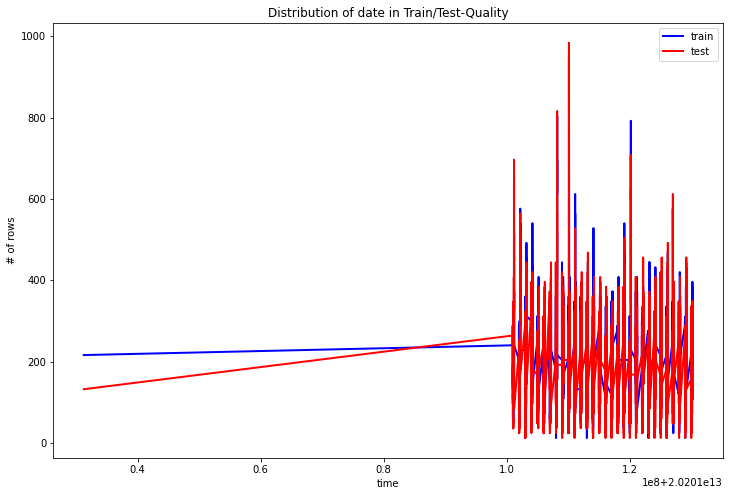

In [ ]:
# train_quality / test_quality - time
# Figure을 정의
plt.figure(figsize = (12,8))

# Train/Test-set 각각에서 특정 date가 몇 번 등장했는지 시각화 시킴
train_quality['time'].alue_counts().sort_index().plot(color='b', lw=2, label='train')
test_quality['time'].value_counts().sort_index().plot(color='r',  lw=2, label='test')

plt.legend()
plt.xlabel("time")
plt.ylabel("# of rows")
plt.title("Distribution of date in Train/Test-Quality");

id 겹치는거 있나 보기


In [ ]:
# Train/Test-set의 고유한 user_id 구함.
train_err_errtype_set = set(train_err['user_id'])
test_err_errtype_set  = set(test_err['user_id'])


# Train/Test-set 고유한 user_id 개수를 구함.
print(f"Train-set에 있는 고유한 user_id 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 user_id 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 user_id 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 user_id 개수 : {len(common_errtype)}")

# Train-set에만 있는 user_id 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 user_id 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 user_id : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 user_id 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 user_id 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 user_id : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 user_id 개수 : 15000


TypeError: ignored

model_nm

In [ ]:
# Train/Test-set의 고유한 model_nm 구함.
train_err_errtype_set = set(train_err['model_nm'])
test_err_errtype_set  = set(test_err['model_nm'])


# Train/Test-set 고유한 model_nm 개수를 구함.
print(f"Train-set에 있는 고유한 model_nm 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 model_nm 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 model_nm 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : {len(common_errtype)}")

# Train-set에만 있는 model_nm 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 model_nm 총 { len(only_train_err_errtype) }개 입니다.")
print(f"Train-set에만 있는 model_nm : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 model_nm 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 model_nm 총 { len(only_test_err_errtype) }개 입니다.")
print(f"Test-set에만 있는 model_nm : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 model_nm 개수 : 9
Test-set에 있는 고유한 model_nm 개수 : 9
Train/Test-set에 공통으로 포함되어 있는 model_nm 개수 : 9
Train-set에만 있는 model_nm 총 0개 입니다.
Train-set에만 있는 model_nm : []
Test-set에만 있는 model_nm 총 0개 입니다.
Test-set에만 있는 model_nm : []


In [ ]:
# Train/Test-set의 고유한 errcode 구함.
train_err_errtype_set = set(train_err['errcode'])
test_err_errtype_set  = set(test_err['errcode'])


# Train/Test-set 고유한 errcode 개수를 구함.
print(f"Train-set에 있는 고유한 errcode 개수 : { len(train_err_errtype_set) }")
print(f"Test-set에 있는 고유한 errcode 개수 : { len(test_err_errtype_set) }")

# Train/Test-set 모두에 포함되어있는 errcode 구함.
print('='* 80)
common_errtype = train_err_errtype_set.intersection(test_err_errtype_set)
print(f"Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : {len(common_errtype)}")

# Train-set에만 있는 errcode 구함.
print('='* 80)
only_train_err_errtype = train_err_errtype_set.difference(test_err_errtype_set)
print(f"Train-set에만 있는 errcode 총 { len(only_train_err_errtype) }개 입니다.")
#print(f"Train-set에만 있는 errcode : { sorted(only_train_err_errtype ) }")

# Test-set에만 있는 errcode 구함.
print('='* 80)
only_test_err_errtype = test_err_errtype_set.difference(train_err_errtype_set)
print(f"Test-set에만 있는 errcode 총 { len(only_test_err_errtype) }개 입니다.")
#print(f"Test-set에만 있는 errcode : { sorted( only_test_err_errtype ) }")

Train-set에 있는 고유한 errcode 개수 : 2806
Test-set에 있는 고유한 errcode 개수 : 2956
Train/Test-set에 공통으로 포함되어 있는 errcode 개수 : 1408
Train-set에만 있는 errcode 총 1398개 입니다.
Test-set에만 있는 errcode 총 1548개 입니다.


missing value

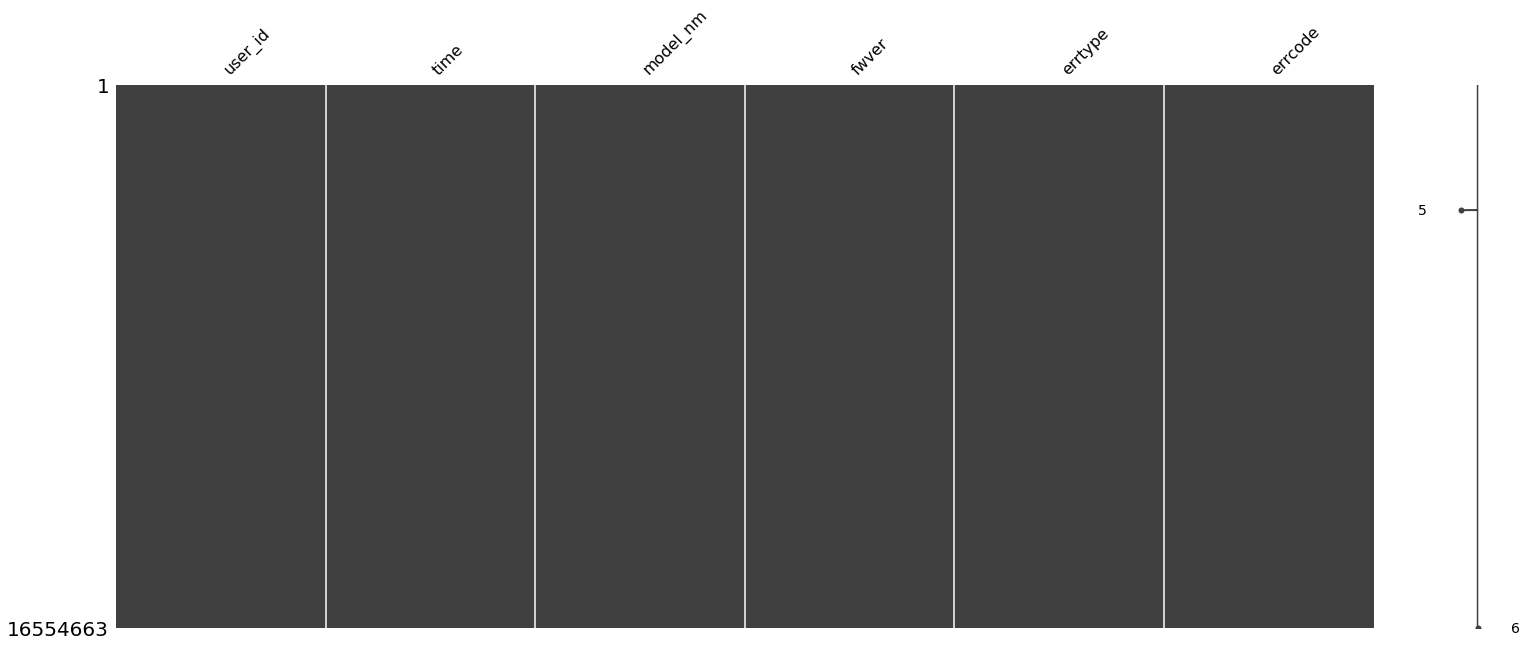

In [ ]:
import missingno as msno

# Missing Values
msno.matrix(train_err)

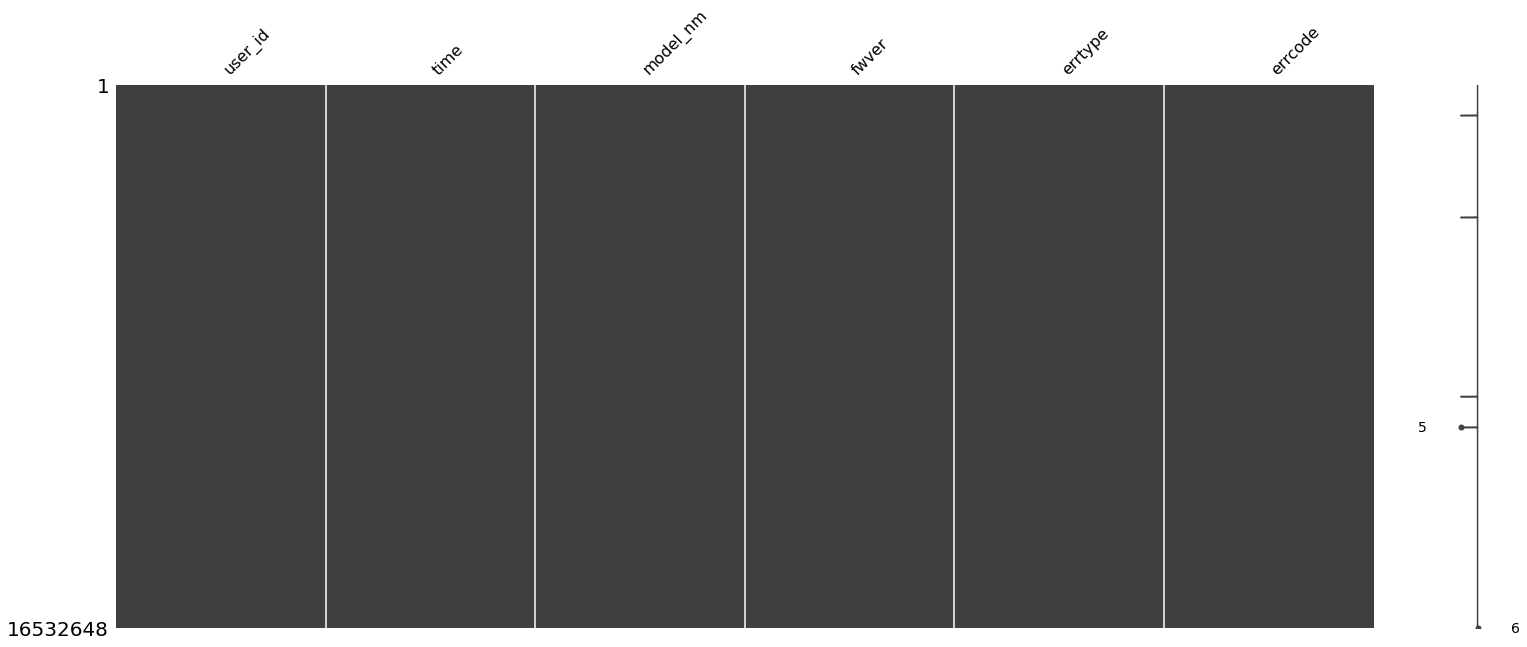

In [ ]:
msno.matrix(test_err)

In [ ]:
train_problem.head()

,user_id,time
0,19224,20201102200000
1,23664,20201116140000
2,15166,20201114130000
3,12590,20201108210000
4,15932,20201103210000


In [ ]:
train_problem['user_id'].value_counts().sort_index()


10001    1
10004    1
10005    1
10006    3
10008    1
        ..
24983    2
24984    1
24990    1
24997    1
24998    1
Name: user_id, Length: 5000, dtype: int64

user_id 가 10001인 예시를 보면

In [ ]:
train_err.loc[train_err["user_id"] == 10001]

,user_id,time,model_nm,fwver,errtype,errcode
317,10001,20201101020415,model_2,04.33.1185,15,1
318,10001,20201101020415,model_2,04.33.1185,15,1
319,10001,20201101020415,model_2,04.33.1185,31,1
320,10001,20201101020415,model_2,04.33.1185,33,2
321,10001,20201101020421,model_2,04.33.1185,12,1
...,...,...,...,...,...,...
2677,10001,20201130193649,model_2,04.33.1261,41,NFANDROID2
2678,10001,20201130214026,model_2,04.33.1261,15,1
2679,10001,20201130222625,model_2,04.33.1261,16,1
2680,10001,20201130222626,model_2,04.33.1261,31,1


In [ ]:
set(train_err["errtype"])

Index(['user_id', 'time', 'model_nm', 'fwver', 'errtype', 'errcode'], dtype='object')

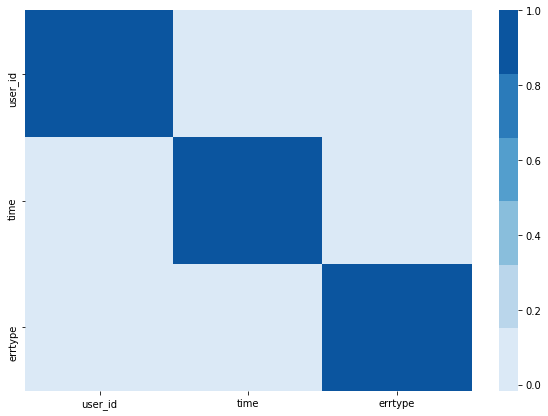

In [ ]:
# 전체 데이터에 대한 상관관계 HeatMap 시각화
display(train_err.columns)
corr = train_err.corr()
cmap = sns.color_palette("Blues")
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(corr, cmap=cmap)

In [ ]:
 train_err.corr()

,user_id,time,errtype
user_id,1.000000,0.004574,0.020254
time,0.004574,1.000000,-0.017023
errtype,0.020254,-0.017023,1.000000


In [ ]:
set(train_err["fwver"])

{'03.11.1141',
 '03.11.1149',
 '03.11.1167',
 '04.16.2641',
 '04.16.3345',
 '04.16.3439',
 '04.16.3553',
 '04.16.3569',
 '04.16.3571',
 '04.22.1442',
 '04.22.1656',
 '04.22.1666',
 '04.22.1684',
 '04.22.1750',
 '04.22.1778',
 '04.33.1095',
 '04.33.1125',
 '04.33.1149',
 '04.33.1171',
 '04.33.1185',
 '04.33.1261',
 '04.73.2237',
 '04.73.2571',
 '04.82.1684',
 '04.82.1730',
 '04.82.1778',
 '05.15.2090',
 '05.15.2092',
 '05.15.2114',
 '05.15.2120',
 '05.15.2122',
 '05.15.2138',
 '05.15.3104',
 '05.66.3237',
 '05.66.3571',
 '10',
 '8.5.3'}

In [ ]:
set(train_err["errcode"])

Text(0.5, 1.0, 'type Values in the Training Set - train ()')

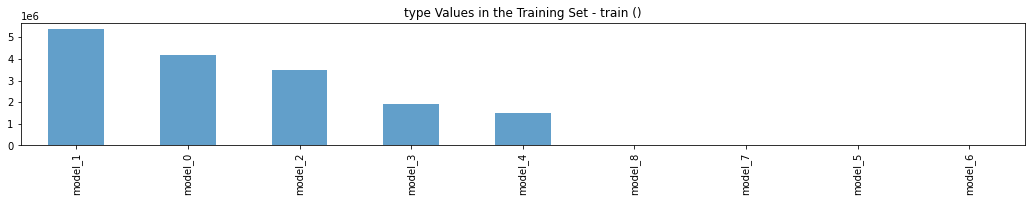

In [ ]:
# model_nm
fig = plt.figure(figsize=(18,9))
plt.subplots_adjust(hspace=.5)

plt.subplot2grid((3,3), (0,0), colspan = 3)
train_err['model_nm'].value_counts()[:100].plot(kind='bar', alpha=0.7)
plt.title('type Values in the Training Set - train ()')

In [ ]:
def func(user_id):
  display(train_err.loc[train_err["user_id"] == user_id])
  display(train_quality.loc[train_quality["user_id"] == user_id])
  display(train_problem.loc[train_problem["user_id"] == user_id])
# display(train_quality.loc[train_quality["user_id"]==10003])

func(10004)

,user_id,time,model_nm,fwver,errtype,errcode
3294,10004,20201101024647,model_0,04.22.1750,13,1
3295,10004,20201101024647,model_0,04.22.1750,12,1
3296,10004,20201101024652,model_0,04.22.1750,14,13
3297,10004,20201101024746,model_0,04.22.1750,6,14
3298,10004,20201101024747,model_0,04.22.1750,7,14
...,...,...,...,...,...,...
4066,10004,20201130214621,model_0,04.22.1778,31,1
4067,10004,20201130214639,model_0,04.22.1778,31,0
4068,10004,20201130221620,model_0,04.22.1778,23,active
4069,10004,20201130221633,model_0,04.22.1778,22,1


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
120,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
121,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,1,0,0,0,0,3,0,0
122,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
123,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
124,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,2,0,0,0,0,3,0,0
125,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
126,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
127,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
128,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
129,20201102232000,10004,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0


,user_id,time
492,10004,20201104120000


In [ ]:


train_problem["user_id"].is_unique




False

In [ ]:
pd.DataFrame(np.array([1,2,3]))[0].is_unique

True

## 보니까 
train_err : 시스템에 발생한 에러 로그

train_quality : 시스템 퀄리티 로그

위에 두개보고 에러났는지 파악

train_problem 에서 불만 접수시간 있음. 근데 불만 확률을 예측하는게 문제임

train_problem는 한사용자가 여러 불만을 접수 할 수도 있음



In [ ]:
display(test_err)
test_quality

,user_id,time,model_nm,fwver,errtype,errcode
0,30000,20201101030227,model_1,04.16.3553,31,1
1,30000,20201101030227,model_1,04.16.3553,33,2
2,30000,20201101030228,model_1,04.16.3553,15,1
3,30000,20201101030256,model_1,04.16.3553,22,1
4,30000,20201101030300,model_1,04.16.3553,11,1
...,...,...,...,...,...,...
16532643,44998,20201130210050,model_1,04.16.3553,40,0
16532644,44998,20201130211831,model_1,04.16.3553,31,1
16532645,44998,20201130211832,model_1,04.16.3553,15,1
16532646,44998,20201130212259,model_1,04.16.3553,16,1


,time,user_id,fwver,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,20201128195000,30000,04.33.1261,0.0,0,0.0,0,0,0,0,5,0,0,2,0,0
1,20201128195000,30000,04.33.1261,0.0,0,0.0,0,0,0,0,5,0,0,2,0,0
2,20201128195000,30000,04.33.1261,0.0,0,0.0,0,0,0,0,5,0,0,2,0,0
3,20201128195000,30000,04.33.1261,0.0,0,0.0,0,0,0,0,5,0,0,2,0,0
4,20201128195000,30000,04.33.1261,0.0,0,0.0,0,0,0,0,5,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
747967,20201125180000,44997,04.22.1750,0.0,0,0.0,0,0,2,0,0,0,0,3,0,0
747968,20201125180000,44997,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
747969,20201125180000,44997,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
747970,20201125180000,44997,04.22.1750,0.0,0,0.0,0,0,0,0,0,0,0,3,0,0
